# Building the SVM model for classifying Port Scanning and DoS attacks

## Overview:

In this notebook we will create an SVM multi-class classifier model for detecting a few network cyber attacks.<br>
The attacks that this model can detect are: 
- Port Scanning on open ports
- Port Scanning on closed ports
- DoS TCP SYN Flood
- DoS HTTP GET Flood<br>  

The model will be based on benign and attack data. The benign data was collected on multiple networks, including our home Ethernet and WiFi networks, and the SCE – Sami Shamoon College of Engineering WiFi network. The attack data was synthesized in Jupyter Notebooks based on actual attacks that we performed in a controlled environment.

## Imports:

In [197]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.svm import SVC

## Creating a scaler object that will be used later:

Based on our testing and research, we concluded that the StandardScaler is the most suitable scaling method for our data.<br>
Its main advantage is that it standardizes features by removing the mean and scaling to unit variance, making the data more suitable for models that assume normally distributed inputs.<br>
This characteristic is especially useful in our case, as it allows the model to better capture statistical deviations from the mean, <br>
which can be indicative of anomalous behavior or attacks, thereby improving detection accuracy.<br>
Additionally, by centering the data and reducing skewness, StandardScaler often leads to faster convergence during model training, enhancing overall training efficiency.

In [198]:
scaler = StandardScaler() #the scaler object is saved later to a .pkl file in order to use it on our real world live data when using the model

## Helper functions:

In [199]:
# updated print_confusion_matrix for multi-class classification
def printConfusionMatrix(cm, y_true, normalize=False):
    # get unique class labels
    labels = sorted(set(y_true))

    # visualize the confusion matrix with a heatmap
    plt.figure(figsize=(8, 6)) #set figure size
    sns.heatmap(cm, annot=True, fmt='.2f' if normalize else 'd', cmap='Blues',
                xticklabels=labels, yticklabels=labels, cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix Heatmap')
    plt.show()


# function to calculate TP, FP, FN, TN for each class
def calculateMetrics(cm):
    metrics = {}
    for classIdx in range(len(cm)):
        tp = cm[classIdx, classIdx]
        fp = cm[:, classIdx].sum() - tp
        fn = cm[classIdx, :].sum() - tp
        tn = cm.sum() - (tp + fp + fn)
        metrics[classIdx] = {'TP': tp, 'FP': fp, 'FN': fn, 'TN': tn}
    return metrics


# function to scale specific columns in the data using a given scaler
def scaleData(scaler, X_train, X_val, X_test, columns_to_scale, fileName = 'standard'):
    # make a copy of the data to avoid modifying the original DataFrame
    X_train_scaled = X_train.copy()
    X_val_scaled = X_val.copy()
    X_test_scaled = X_test.copy()

    # fit and transform the specified columns for X_train
    X_train_scaled[columns_to_scale] = scaler.fit_transform(X_train[columns_to_scale])
    # transform only for X_val (using the fit from X_train)
    X_val_scaled[columns_to_scale] = scaler.transform(X_val[columns_to_scale])
    # transform only for X_test (using the fit from X_train)
    X_test_scaled[columns_to_scale] = scaler.transform(X_test[columns_to_scale])
    joblib.dump(scaler, fileName + '_scaler.pkl') #save the scaler object for later use

    # return the scaled dataframes
    return X_train_scaled, X_val_scaled, X_test_scaled


# function for counting the number of different label types and plotting the result
def countAndPlot(y, labelValues = ['Benign', 'Port Scanning', 'DoS']):
    # count the number of rows for each label
    labelCounts = y.value_counts().sort_index()

    # calculate additional counts
    countBenign = labelCounts[0] if 0 in labelCounts.index else 0
    countOthers = labelCounts.drop(0).sum() if 0 in labelCounts.index else labelCounts.sum()

    # plot the counts
    plt.figure(figsize=(8, 6))
    plt.bar(labelCounts.index, labelCounts.values, color='skyblue', edgecolor='black')
    plt.xticks(labelCounts.index, labels=[f'{labelValues[int(lable)]}' for lable in labelCounts.index])

    # add labels and show the plot
    plt.xlabel('Label Type')
    plt.ylabel('Number of Rows')
    plt.title(f'Row Counts for Each Label Type\n(Benign: {countBenign}, Others: {countOthers})')
    plt.tight_layout()
    plt.show()


# function for removing null and infi values
def removeNullAndInfi(X_train, X_val, X_test):
    X_train.fillna(X_train.mean(), inplace=True)
    X_val.fillna(X_val.mean(), inplace=True)
    X_test.fillna(X_test.mean(), inplace=True)

    X_train.replace(['max', float('inf'), float('-inf')], 1e10, inplace=True)
    X_val.replace(['max', float('inf'), float('-inf')], 1e10, inplace=True)
    X_test.replace(['max', float('inf'), float('-inf')], 1e10, inplace=True)

    # ensure no NaN or Inf values remain
    assert not X_train.isnull().any().any(), 'X_train still contains NaN values!'
    assert not X_val.isnull().any().any(), 'X_val still contains NaN values!'
    assert not X_test.isnull().any().any(), 'X_test still contains NaN values!'
    assert not (X_train == float('inf')).any().any(), 'X_train still contains infinite values!'
    assert not (X_val == float('inf')).any().any(), 'X_val still contains infinite values!'
    assert not (X_test == float('inf')).any().any(), 'X_test still contains infinite values!'


# function for training an SVM model
def trainAndEvaluateSvm(X_train, X_val, X_test, y_train, y_val, y_test):
    # initialize the SVM model
    model = SVC(kernel='linear', C=1)
    
    # fit the model
    model.fit(X_train, y_train)

    # predict and calculate accuracy
    y_pred_train = model.predict(X_train)
    y_pred_val = model.predict(X_val)
    y_pred_test = model.predict(X_test)

    # calculate accuracy for train, val and test
    trainAccuracy = accuracy_score(y_train, y_pred_train)
    valAccuracy = accuracy_score(y_val, y_pred_val)
    testAccuracy = accuracy_score(y_test, y_pred_test)

    # generate the confusion matrix
    cm = confusion_matrix(y_test, y_pred_test)

    # calculate TP, FP, FN, TN for each class
    metrics = calculateMetrics(cm)

    # generate the classification report
    classReport = classification_report(y_test, y_pred_test, output_dict=False)

    # print results
    print(f'Train Accuracy: {trainAccuracy:.5f}')
    print(f'Validation Accuracy: {valAccuracy:.5f}')
    print(f'Test Accuracy: {testAccuracy:.5f}')
    print('\nConfusion Matrix:')
    print(cm)
    print('\nMetrics for each class:')
    for classIdx, values in metrics.items():
        print(f'Class {classIdx} -> TP: {values['TP']}, FP: {values['FP']}, FN: {values['FN']}, TN: {values['TN']}')

    print('\nClassification Report:')
    print(classReport)

    # visualize the confusion matrix
    printConfusionMatrix(cm, y_test)

    return model

---

## Import and merge attack datasets:

### Importing DoS attack datasets:

In [200]:
dosSamples1 = pd.read_csv('dos_hulk_dataset.csv')
print(f'Dataset Shape: {dosSamples1.shape}')
dosSamples1.head(3)

Dataset Shape: (25000, 27)


,Number of Ports,Average Packet Length,Packet Length Min,Packet Length Max,Packet Length Std,Packet Length Variance,Total Length of Fwd Packet,Fwd Packet Length Max,Fwd Packet Length Mean,Fwd Packet Length Min,...,Subflow Fwd Bytes,SYN Flag Count,ACK Flag Count,RST Flag Count,Flow Duration,Packets Per Second,IAT Max,IAT Mean,IAT Std,Label
0,1,157.032114,70,441,192.240657,16051.572222,869040.073079,338,87.699995,14,...,0.000000,1362,4402.0,726.0,23.495292,420.400739,29.559196,0.002829,0.012734,DoS
1,1,129.676991,56,614,149.406645,12571.228482,898988.512441,437,102.681607,16,...,646099.234495,1849,6099.0,945.0,21.151779,457.704379,26.524602,0.002039,0.040581,DoS
2,1,92.415522,47,359,81.518983,9342.523391,507969.236120,368,74.992729,15,...,433303.772845,2943,9460.0,1584.0,6.286134,1198.647358,0.854488,0.000586,0.004252,DoS


In [201]:
dosSamples2 = pd.read_csv('dos_goldeneye_dataset.csv')
print(f'Dataset Shape: {dosSamples2.shape}')
dosSamples2.head(3)

Dataset Shape: (25000, 27)


,Number of Ports,Average Packet Length,Packet Length Min,Packet Length Max,Packet Length Std,Packet Length Variance,Total Length of Fwd Packet,Fwd Packet Length Max,Fwd Packet Length Mean,Fwd Packet Length Min,...,Subflow Fwd Bytes,SYN Flag Count,ACK Flag Count,RST Flag Count,Flow Duration,Packets Per Second,IAT Max,IAT Mean,IAT Std,Label
0,1,105.587820,48,811,107.975975,21606.250764,8.379445e+05,784,66.001649,17,...,0.0,2824,9100.0,0,44.073579,240.713811,6.278590,0.005171,0.099604,DoS
1,1,147.823620,80,1075,140.517726,30009.173407,1.160707e+06,548,87.131647,42,...,0.0,1976,6216.0,0,2.123064,5066.773119,3.415648,0.000270,0.004027,DoS
2,1,130.944127,49,656,173.492877,26738.347462,7.905741e+05,664,113.250776,14,...,0.0,2271,7282.0,0,13.394617,555.752803,20.155189,0.001698,0.009695,DoS


In [202]:
dosSamples3 = pd.read_csv('dos_hulk_goldeneye_closed_port_dataset.csv')
print(f'Dataset Shape: {dosSamples3.shape}')
dosSamples3.head(3)

Dataset Shape: (5000, 27)


,Number of Ports,Average Packet Length,Packet Length Min,Packet Length Max,Packet Length Std,Packet Length Variance,Total Length of Fwd Packet,Fwd Packet Length Max,Fwd Packet Length Mean,Fwd Packet Length Min,...,Subflow Fwd Bytes,SYN Flag Count,ACK Flag Count,RST Flag Count,Flow Duration,Packets Per Second,IAT Max,IAT Mean,IAT Std,Label
0,1,83,83,83,0,0,32427.0,42,42,42,...,0.00000,918,0,0,9.105900,62.550228,5.784082,0.016451,0.235144,DoS
1,1,76,76,76,0,0,30171.0,42,42,42,...,29065.74806,961,0,0,10.333337,63.646632,6.623608,0.017205,0.257115,DoS
2,1,79,79,79,0,0,43118.0,37,37,37,...,0.00000,981,0,0,10.089529,58.571270,6.805950,0.009695,0.192596,DoS


In [203]:
dosSamples4 = pd.read_csv('dos_hping_dataset.csv')
print(f'Dataset Shape: {dosSamples4.shape}')
dosSamples4.head(3)

Dataset Shape: (25000, 27)


,Number of Ports,Average Packet Length,Packet Length Min,Packet Length Max,Packet Length Std,Packet Length Variance,Total Length of Fwd Packet,Fwd Packet Length Max,Fwd Packet Length Mean,Fwd Packet Length Min,...,Subflow Fwd Bytes,SYN Flag Count,ACK Flag Count,RST Flag Count,Flow Duration,Packets Per Second,IAT Max,IAT Mean,IAT Std,Label
0,1,51,51,51,0,0,229836.0,27,27,27,...,228518.151688,10388,0,0,28.079277,310.892567,20.040884,0.002443,0.191601,DoS
1,1,51,51,51,0,0,200436.0,34,34,34,...,0.000000,8557,0,0,0.168401,56547.432023,0.009349,0.000018,0.000183,DoS
2,1,63,63,63,0,0,183146.0,22,22,22,...,157209.547388,8256,0,0,11.761408,974.500926,8.888762,0.001403,0.073439,DoS


### Importing Port Scanning attack datasets:

In [204]:
portSamples1 = pd.read_csv('port_scan_open_port_dataset.csv')
print(f'Dataset Shape: {portSamples1.shape}')
portSamples1.head(3)

Dataset Shape: (40000, 27)


,Number of Ports,Average Packet Length,Packet Length Min,Packet Length Max,Packet Length Std,Packet Length Variance,Total Length of Fwd Packet,Fwd Packet Length Max,Fwd Packet Length Mean,Fwd Packet Length Min,...,Subflow Fwd Bytes,SYN Flag Count,ACK Flag Count,RST Flag Count,Flow Duration,Packets Per Second,IAT Max,IAT Mean,IAT Std,Label
0,974,63.190503,51,56,0.113551,0.012073,40364,24,23.0,22,...,42242.229606,1582,4,4,4.355784,538.240103,0.758923,0.003641,0.034735,PortScan
1,2619,47.408196,60,62,0.050273,0.003952,154842,19,19.0,19,...,100245.886493,4230,7,7,26.008828,272.061283,2.535794,0.002964,0.036392,PortScan
2,4240,65.711278,55,58,0.063255,0.004335,184431,22,22.0,22,...,94618.667656,10004,9,9,12.110924,537.309430,1.398220,0.001357,0.021685,PortScan


In [205]:
portSamples2 = pd.read_csv('port_scan_closed_port_dataset.csv')
print(f'Dataset Shape: {portSamples2.shape}')
portSamples2.head(3)

Dataset Shape: (20000, 27)


,Number of Ports,Average Packet Length,Packet Length Min,Packet Length Max,Packet Length Std,Packet Length Variance,Total Length of Fwd Packet,Fwd Packet Length Max,Fwd Packet Length Mean,Fwd Packet Length Min,...,Subflow Fwd Bytes,SYN Flag Count,ACK Flag Count,RST Flag Count,Flow Duration,Packets Per Second,IAT Max,IAT Mean,IAT Std,Label
0,1335,85,85,85,0,0,84753,47,47,47,...,0.0,2715.0,0,0,43.505375,109.041123,1.747802,0.015959,0.027676,PortScan
1,2002,58,58,58,0,0,126961,20,20,20,...,0.0,4069.0,0,0,45.022328,50.822431,1.911237,0.012356,0.023156,PortScan
2,1722,46,46,46,0,0,105668,43,43,43,...,0.0,3503.0,0,0,38.492006,50.256048,1.343713,0.010860,0.015334,PortScan


### Merging the attack datasets:

In [206]:
# merge the port attack datasets
mergedPortDataset = pd.concat([portSamples1, portSamples2], axis=0)
mergedPortDataset = mergedPortDataset.sample(frac=1, random_state=42).reset_index(drop=True)
print(f'Dataset Shape: {mergedPortDataset.shape}')

Dataset Shape: (60000, 27)


In [207]:
# sample dos attack dataset
mergedDosDataset = pd.concat([dosSamples1, dosSamples2, dosSamples3, dosSamples4], axis=0) 
mergedDosDataset = mergedDosDataset.sample(frac=1, random_state=42).reset_index(drop=True)
print(f'Dataset Shape: {mergedDosDataset.shape}')

Dataset Shape: (80000, 27)


In [208]:
# merge the attack datasets
mergedPortDosDataset = pd.concat([mergedPortDataset, mergedDosDataset], axis=0) 
mergedPortDosDataset = mergedPortDosDataset.sample(frac=1, random_state=42).reset_index(drop=True)
print(f'Dataset Shape: {mergedPortDosDataset.shape}')
mergedPortDosDataset.head(3)

Dataset Shape: (140000, 27)


,Number of Ports,Average Packet Length,Packet Length Min,Packet Length Max,Packet Length Std,Packet Length Variance,Total Length of Fwd Packet,Fwd Packet Length Max,Fwd Packet Length Mean,Fwd Packet Length Min,...,Subflow Fwd Bytes,SYN Flag Count,ACK Flag Count,RST Flag Count,Flow Duration,Packets Per Second,IAT Max,IAT Mean,IAT Std,Label
0,2762,60.958577,50,52,0.080674,0.006821,161385.000000,21,21.000000,21,...,0.000000,6181.0,5.0,5.0,11.242770,814.077613,1.855684,0.001662,0.018485,PortScan
1,1035,48.946101,59,68,0.097012,0.010765,43835.000000,26,20.000000,14,...,52040.711206,1707.0,5.0,5.0,3.510861,459.589729,1.089983,0.002741,0.025495,PortScan
2,1,90.761162,52,396,113.712439,12078.389397,639735.541105,393,72.476555,26,...,469072.663716,1726.0,5467.0,1208.0,13.381403,648.032372,0.836924,0.001231,0.007015,DoS


---

## Import benign dataset:

In [209]:
benign = pd.read_csv('port_scan_dos_benign_full.csv')
print(f'Dataset Shape: {benign.shape}')

Dataset Shape: (253052, 27)


In [210]:
# merge the benign datasets
mergedBenign = pd.concat([benign], axis=0)
mergedBenign = mergedBenign.sample(frac=1, random_state=42).reset_index(drop=True)

# adding a label to the dataset
mergedBenign['Label'] = 'BENIGN'

print(f'Dataset Shape: {mergedBenign.shape}')
mergedBenign.tail(3)

Dataset Shape: (253052, 27)


,Number of Ports,Average Packet Length,Packet Length Min,Packet Length Max,Packet Length Std,Packet Length Variance,Total Length of Fwd Packet,Fwd Packet Length Max,Fwd Packet Length Mean,Fwd Packet Length Min,...,Subflow Fwd Bytes,SYN Flag Count,ACK Flag Count,RST Flag Count,Flow Duration,Packets Per Second,IAT Max,IAT Mean,IAT Std,Label
253049,1,95.666667,66,124,26.113002,681.888889,262,90,87.333333,82,...,0.0,0,6,0,0.000494,12145.667954,0.000339,0.000099,0.000126,BENIGN
253050,1,216.333333,102,425,147.775355,21837.555556,487,371,162.333333,48,...,0.0,0,0,0,0.103637,28.947196,0.102381,0.051818,0.050563,BENIGN
253051,1,86.600000,74,113,16.144349,260.640000,123,59,41.000000,20,...,0.0,0,5,0,0.006931,721.389701,0.006633,0.001733,0.002830,BENIGN


### Checking for duplications in the benign dataset:

In [211]:
# check for duplicates in the subset of selected features
duplicatesMask = mergedBenign.duplicated(keep = 'first')
numDuplicates = duplicatesMask.sum()
print(f'Number of duplicate rows based on selected features: {numDuplicates}')

# remove duplicates directly
mergedBenign = mergedBenign.drop_duplicates(keep = 'first')
print(f'Shape of dataset after removing duplicates: {mergedBenign.shape}')

Number of duplicate rows based on selected features: 0
Shape of dataset after removing duplicates: (253052, 27)


In [212]:
mergedBenign.head(5)

,Number of Ports,Average Packet Length,Packet Length Min,Packet Length Max,Packet Length Std,Packet Length Variance,Total Length of Fwd Packet,Fwd Packet Length Max,Fwd Packet Length Mean,Fwd Packet Length Min,...,Subflow Fwd Bytes,SYN Flag Count,ACK Flag Count,RST Flag Count,Flow Duration,Packets Per Second,IAT Max,IAT Mean,IAT Std,Label
0,1,229.476190,54,1466,352.146022,124006.820862,3505,1432,292.083333,22,...,3505.0,0,21,0,1.653092,12.703468,1.553223,0.082655,0.337549,BENIGN
1,1,810.991751,90,1292,580.267837,336710.762433,7254671,1238,1206.698436,36,...,0.0,0,0,0,3.249300,3021.881633,0.330179,0.000331,0.005877,BENIGN
2,1,213.400000,82,393,113.074489,12785.840000,897,359,179.400000,48,...,448.5,0,0,0,9.830695,0.508611,7.884071,2.457674,3.158192,BENIGN
3,1,202.666667,95,344,120.107128,14425.722222,1538,290,256.333333,88,...,769.0,0,0,0,13.747809,0.872866,11.225628,1.249801,3.181185,BENIGN
4,1,77.000000,77,77,0.000000,0.000000,86,43,43.000000,43,...,86.0,0,0,0,6.006072,0.332996,6.006072,6.006072,0.000000,BENIGN


### Saving the benign dataset in a CSV format for future use:

In [213]:
mergedBenign.to_csv('port_scan_dos_benign_full.csv', index=False)

---

## Merging benign dataset with attack dataset:

In [214]:
mergedDataset = pd.concat([mergedPortDosDataset, mergedBenign], axis=0)
mergedDataset = mergedDataset.sample(frac=1, random_state=42).reset_index(drop=True)

print(f'Dataset Shape: {mergedDataset.shape}')
mergedDataset.tail(3)

Dataset Shape: (393052, 27)


,Number of Ports,Average Packet Length,Packet Length Min,Packet Length Max,Packet Length Std,Packet Length Variance,Total Length of Fwd Packet,Fwd Packet Length Max,Fwd Packet Length Mean,Fwd Packet Length Min,...,Subflow Fwd Bytes,SYN Flag Count,ACK Flag Count,RST Flag Count,Flow Duration,Packets Per Second,IAT Max,IAT Mean,IAT Std,Label
393049,1003,59.935699,64,68,0.102176,0.013023,49394.0,25,23.5,22,...,49830.943597,1923.0,5.0,5.0,3.668587,609.964651,1.168702,0.003019,0.027617,PortScan
393050,1,60.500000,55,66,5.500000,30.250000,32.0,32,32.0,32,...,0.000000,0.0,2.0,0.0,0.052326,38.221943,0.052326,0.052326,0.000000,BENIGN
393051,988,51.941590,64,75,0.088120,0.010125,53715.0,22,15.5,9,...,42153.078919,2106.0,6.0,6.0,4.602199,351.396824,0.901162,0.003643,0.036485,PortScan


### Saving the full dataset that the model will be trained and tested on:

In [215]:
mergedDataset.to_csv('final_port_scan_dos_dataset.csv', index=False)

---

## Evaluating Feature Importance

In this part of the code we will be evaluating the feature importance of the features we selected for the Port Scanning & DoS SMV model. <br>
The importance will be evaluated using an SVM classifier with linear kernal on the Scaled Training data.<br>
This code will show that most of the features we ended up selecting for the model <u>are very important</u> for the classification success of the model.

In [216]:
merged_dataset = mergedDataset.copy() #creating a copy to not effect the rest of the code

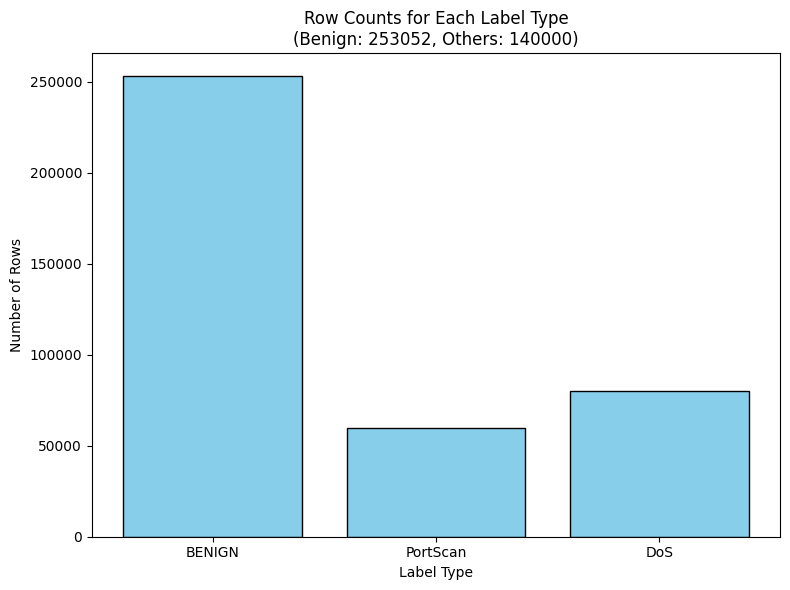

In [217]:
# train-test split
X = merged_dataset.drop(columns=['Label'])
y = merged_dataset['Label']

mappingLabels = {
    'BENIGN': 0, 
    'PortScan': 1,
    'DoS': 2
}
y = y.map(mappingLabels)

# split data into 70% train, 30% temp (for validation + test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

# split temp into 15% validation and 15% test 
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

columnsToScale = [column for column in X_train.columns if column != 'Label'] 
X_train_scaled, X_val_scaled, X_test_scaled = scaleData(scaler, X_train, X_val, X_test, columnsToScale, 'port_scan_dos')

countAndPlot(y, ['BENIGN', 'PortScan', 'DoS'])

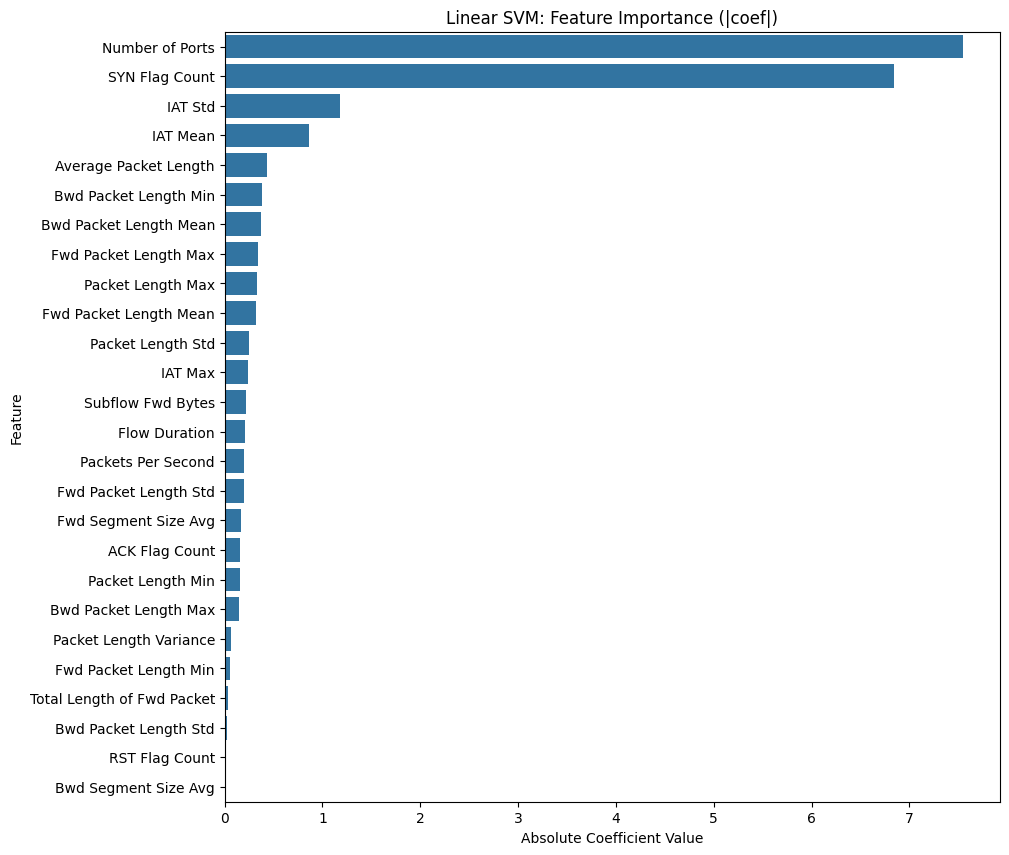

In [218]:
# create the linear SVM classifier and train it on the train data and calculate feature importance
svm = SVC(kernel='linear', C=1, random_state=0)
svm.fit(X_train_scaled, y_train)

# extract absolute coefficient magnitudes for each feature
coef = np.abs(svm.coef_[0])
feat_imp = pd.Series(coef, index=X_train_scaled.columns).sort_values(ascending=False)

# plot the results of the feature importance coefficient calculations
plt.figure(figsize=(10,10))
sns.barplot(x=feat_imp.values, y=feat_imp.index)
plt.title('Linear SVM: Feature Importance (|coef|)')
plt.xlabel('Absolute Coefficient Value')
plt.ylabel('Feature')
plt.show()

---

## Building the SVM model

Shapes:
  X_train: (275136, 26), X_val: (58958, 26), X_test: (58958, 26), y_train: (275136,), y_val: (58958,), y_test: (58958,)


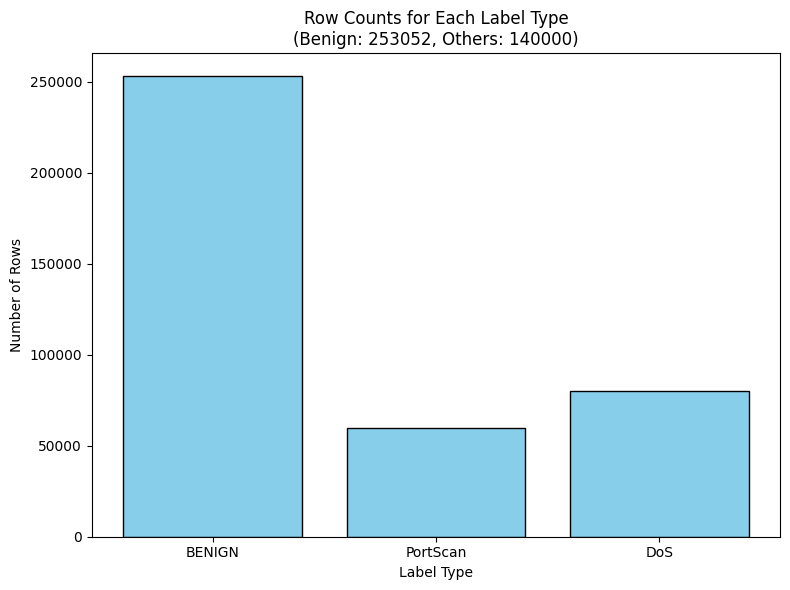

Train Accuracy: 1.00000
Validation Accuracy: 1.00000
Test Accuracy: 1.00000

Confusion Matrix:
[[38004     0     0]
 [    0  9025     0]
 [    0     0 11929]]

Metrics for each class:
Class 0 -> TP: 38004, FP: 0, FN: 0, TN: 20954
Class 1 -> TP: 9025, FP: 0, FN: 0, TN: 49933
Class 2 -> TP: 11929, FP: 0, FN: 0, TN: 47029

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     38004
           1       1.00      1.00      1.00      9025
           2       1.00      1.00      1.00     11929

    accuracy                           1.00     58958
   macro avg       1.00      1.00      1.00     58958
weighted avg       1.00      1.00      1.00     58958



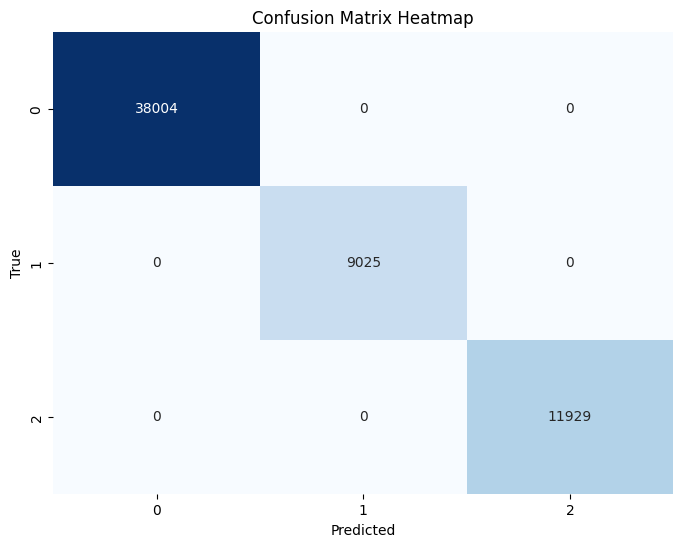

Runtime: 0.08 minutes
Model saved successfully!


In [219]:
# train-test split
X = mergedDataset.drop(columns=['Label'])
y = mergedDataset['Label']

mappingLabels = {
    'BENIGN': 0, 
    'PortScan': 1,
    'DoS': 2
}
y = y.map(mappingLabels)

# split data into 70% train, 30% temp (for validation + test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

# split temp into 15% validation and 15% test 
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Shapes:\n  X_train: {X_train.shape}, X_val: {X_val.shape}, X_test: {X_test.shape}, y_train: {y_train.shape}, y_val: {y_val.shape}, y_test: {y_test.shape}")
countAndPlot(y, ['BENIGN', 'PortScan', 'DoS'])

# remove null and scale
removeNullAndInfi(X_train, X_val, X_test)
columnsToScale = [column for column in X_train.columns if column != 'Label'] 
X_train_scaled, X_val_scaled, X_test_scaled = scaleData(scaler, X_train, X_val, X_test, columnsToScale, 'port_scan_dos')

# train the model and save the output
start_time = time.time()
model = trainAndEvaluateSvm(X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test)
runtime = (time.time() - start_time)/60
print(f'Runtime: {runtime:.2f} minutes')

joblib.dump(model, 'port_scan_dos_svm_model.pkl')  
print('Model saved successfully!')

## Results:

As a result of both the training and testing phases of our SVM model, we observed that the classifier achieved an impressive 100% accuracy in detecting the types of attacks it was trained on. <br>
During testing, there were no false positives or false negatives, indicating that the model made correct predictions across the board. This outcome demonstrates that the SVM model is highly effective in recognizing the specific attack patterns it learned during training—namely Port Scanning, DoS TCP SYN Flood, and DoS HTTP GET Flood.<br> 

Furthermore, since this is a machine learning-based model, its strength lies in its ability to generalize. While it was trained on attack patterns generated by specific tools, it is very likely to maintain strong performance when encountering the same types of attacks executed through different means or tools, thanks to its ability to identify underlying behavioral patterns rather than tool-specific signatures.<br>

The dataset used for training and testing included a total of 393,052 UDP & TCP network flows: 253,052 benign flows, 60,000 Port Scanning attack flows, and 80,000 DoS attack flows. As previously mentioned, the benign traffic was manually collected from various environments, including our home Ethernet and WiFi networks, as well as public WiFi networks available at the SCE college campus. This variety in data sources further enhances the robustness and real-world applicability of our trained model.